# <h1 style="color:gray;text-align:center;">SOUTH AFRICA LANGUAGE IDENTIFICATION</h1>

#### Overview
South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

The country is multilingual with 11 official languages, each of which is guaranteed equal status. Most South Africans are multilingual and able to speak at least two or more of the official languages.
From [South African Government](https://www.gov.za/about-sa/south-africas-people)


![South Africa Languages Composition](assets/South-Africa-Languages-snapshot.jpg)


With such a multilingual population, it is only obvious that our systems and devices also communicate in multi-languages.

#### Objective
We are going to examine a text which is in any of South Africa's 11 Official languages and identify which language the text is in, NLP's Language Identification: the task of determining the natural language that a piece of text is written in.

## Imports and Dataset Loading
Let's import modules that we are going to use

In [1]:
import warnings # to filter out warnings in the jupyter notebook
warnings.filterwarnings('ignore') # we will ignore all warning and not show them

# Imports to load, explore, wrangle and visualize
import numpy as np # for working with our array objects
import pandas as pd # for loading and manipulateing our datasets
import matplotlib.pyplot as plt # for plotting our visualizations
import seaborn as sns # for plotting our visualizations

# Imports for preprocessing, model development and evaluation
from sklearn import metrics # for evaluating the performance of our model
from sklearn.preprocessing import LabelEncoder # for encodeing our categorical labels
from sklearn.model_selection import train_test_split # for split the train and test data
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer # for extracting features from the text
from sklearn.model_selection import GridSearchCV # for model tuning

# model import to consider
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

#### Loading the Datasets
Let's now load a dataset for training our model

In [2]:
df = pd.read_csv('train_set.csv') # load training dataset
df.head() # View the first five rows of dataset

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


Viewing the first few rows of our data set, we can see that we have a **``lang_id``** column identifying the south african language, and a **``text``** column that has text specific to that language.
We are going to train a model that can correctly identify the language of a given text using these two columns.

## 1. Exploratory Data Analysis

Before diving into training machine learning models, we should look at our dataset for insights.
We will explore insights like the distribution of the languages by viewing overall information, the shape of our dataset, and the languages the distribution of texts for each of the languages etc.

### 1.0 Overall Insights

In [3]:
# View the shape of the dataset
df.shape

(33000, 2)

In [4]:
# View the information of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [5]:
# View the missing values in the dataset
df.isna().sum()

lang_id    0
text       0
dtype: int64

- The dataset has *33,000 rows and 2 columns*. Also, all of the columns are of *object* data type and that there are no missing values in our dataset.

### 1.1 Language Distribution

Let's now look at the distribution of the dataset according to the languages:

In [6]:
languages = df['lang_id'].unique().tolist() # Get all the unique languages
print(f'There are {len(languages)} in total') # Let's see how many there are
sorted(languages) # Let's view the languages

There are 11 in total


['afr', 'eng', 'nbl', 'nso', 'sot', 'ssw', 'tsn', 'tso', 'ven', 'xho', 'zul']

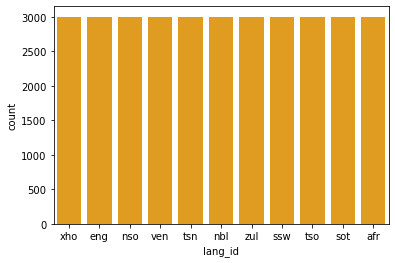

In [7]:
df['lang_id'].value_counts() # Get the number of values per language
ax = sns.countplot(df['lang_id'], data = df, color='Orange') # Plot a bar plot to visualize the distribution

- In total there are *11* languages that we will be predict for
- The data is distributed uniformly among the 11 languages hence we have balance data

### 1.1 Text Distribution

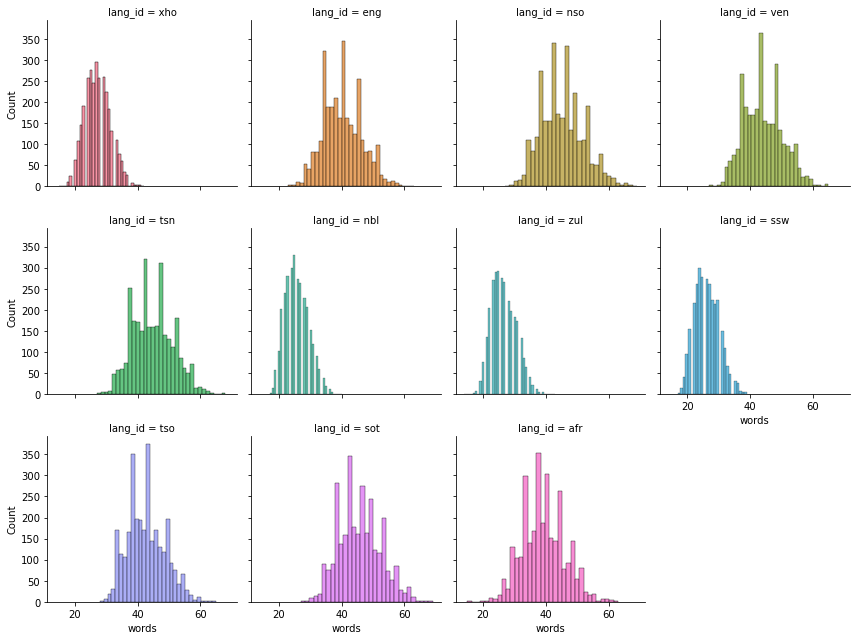

In [8]:
text_dist = df.copy() # Make copy of dataframe
# Split the text into a list of words and count the number of words in the text
text_dist['words'] = text_dist['text'].apply(
    lambda text: len(text.split())
) 

fig = sns.FacetGrid(text_dist, col = 'lang_id',col_wrap=4, hue='lang_id') # Create a grid to visualize the languages
fig.map(sns.histplot, 'words')  # plot a histogram to visualize the ditribution of words for each of the languages

## 2. Data Processing/Engineering

For our models to process our data, we need to transform the text toa more manageable representation. We will use the ``Labelencoder`` to encode our our labels and also, extract our features from the text using the ``TFIDFTransformerr``. Skit learn's ``TFIDFTransformer`` calculates a measure called Term Frequency, Inverse Document Frequency, abbreviated to tf-idf.
Before we transform our text, we will use ``CounterVectorizer`` to create our bag of words model.

Let's encode the **``lang_id``** as the target labels

In [9]:
le = LabelEncoder() # Instatiate an encoder of our labels
le.fit(df['lang_id']) # Let's encode our label data

LabelEncoder()

Let's now access our classes and view them

In [10]:
le.classes_

array(['afr', 'eng', 'nbl', 'nso', 'sot', 'ssw', 'tsn', 'tso', 'ven',
       'xho', 'zul'], dtype=object)

Now, let's extact and transform our text features using skit learn's ``CounterVectorizer`` and ``TfidfTransformer`` respectively.
We instantiate the vectorizer with the following:
- **min_df** of *2*, the minimum numbers of documents a word must be present in to be kept.
- **ngram_range** is set to *(1, 2)* to indicate that we want to consider both unigrams and bigrams.

In [11]:
vect = CountVectorizer(
    min_df = 2,
    ngram_range = (1, 2)
) # Instatiate vectorizer with min_df = 2 and ngram_range = (1, 2)
tfidf_trans = TfidfTransformer() # Instatiate our TFIDF transformer

X = vect.fit_transform(df['text']) # vectorize  the text to get our features
X_trans = tfidf_trans.fit_transform(X) # transform the vectorized text

y = le.transform(df['lang_id']) # Transform our lang_id to get our target

In [12]:
# Now let's view the shape of our features
print(X_trans.shape)

(33000, 207493)


Now, each of 33000 language classifications is represented by 207493 features, representing the tf-idf score for different unigrams and bigrams.

## 3. Model Development

Having transformed and created all the features and labels, it is time to train the classifiers. There are a number of algorithms we can use for this type of problem, but we will consider four of them i.e.:
1. (MultinomialNB) Naive Bayes Classifier
2. LogisticRegression Classifier
3. (SVC) Support Vector Machine Classifier
4. Random Forest Classifier

We will split the features and labels to training and testing sets, create a function to fit our models and finally fit the four model.

## 3.1. Model Training

We, will split othe features and labels to training and testing sets to have our ``X_train``, ``y_train`` , ``X_test`` and ``y_test``. This will enable us to evaluate the performance of our fitted models on the unseen data

In [13]:
# Split the labels and target into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_trans, y, test_size=0.2, random_state=42)

Let's create a list with the models we are interested to fit and their associated hyperparameters we need to later tune the for better performance

In [14]:
# Create a dict containing the various models to evaluate
# include the parameters we are interested to tune for each model
models_list = [
    # define the MultinomialNB Classifier
    {
        'model': MultinomialNB(), # instantiate the model
        'param_grid': { # set hyper parameters for model tuning
            'alpha': [0.0001, 0.001, 0.1, 1, 10]
        }
    },
    # define the Support Vector Classifier
    {
        'model': SVC(), # instantiate the model
        'param_grid': { # set hyper parameters for model tuning
            'C': [1, 10, 20],
            'gamma': [0.1, 0.01,0.001],
        }
    },
    # define the Logistic Regression Classifier
    {
        'model': LogisticRegression(), # instantiate the model
        'param_grid': { # set hyper parameters for model tuning
            'C' : [0.001, 0.01, 0.1],
            'max_iter' : [100, 250, 500]
        }
    },
    # define the Random Forest Classifier
    {
        'model': RandomForestClassifier(), # instantiate the model
        'param_grid': { # set hyper parameters for model tuning
            'max_depth': [10, 20, 40,  None],
            'n_estimators': [100, 200, 250]
        }
    }
]

Let's then create a function that will take in the ``X_train``, ``y_train`` and the **models** as inputs, and then fits our models on the training data.

In [15]:
# Function to fit the base models for on the data
# to view their initial performance
def fit_models(X_train, y_train, models):
    models_list = []
    for item in models:
        model = item['model']
        model.fit(X_train, y_train)
        models_list.append((model.__class__.__name__, model))
    return models_list

Also, lets, create another funstion that will take in ``X_test``, ``y_test`` and the **fitted models** and evaluates them on our selected performances

In [16]:
# Function to predict targets for X_test
# and to return the accuracy and f1 scores, classification report, and confusion matrix
def evaluate_models(X_test, y_test, models):
    accuracy_scores = []
    f1_scores = []
    classification_reports = []
    confusion_matrices = []

    for (name, fitted_model) in fitted_models:
        y_pred = fitted_model.predict(X_test)
        accuracy_scores.append( # add to accuracy_scores the accuracy of model
            metrics.accuracy_score(y_test, y_pred) # find the accuracy
        )
        f1_scores.append( # add to f1_scores the f1 score of model
            metrics.f1_score(y_test, y_pred, average='weighted') # find the f1 score
        )
        classification_reports.append( # add to f1_scores the f1 score of model
            (name.upper(), metrics.classification_report(y_test, y_pred))
        )
        confusion_matrices.append(
            (name.upper(), metrics.confusion_matrix(y_test, y_pred))
        )
    return f1_scores, classification_reports, confusion_matrices

## 3.2. Model Testing

We will now train the models

In [17]:
# Fit the various model
fitted_models = fit_models(X_train, y_train, models_list)
fitted_models

[('MultinomialNB', MultinomialNB()),
 ('SVC', SVC()),
 ('LogisticRegression', LogisticRegression()),
 ('RandomForestClassifier', RandomForestClassifier())]

Let's now evaluate our models to see their f1 and accuracy scoring and 

In [18]:
# Now we predict the target for the X_test for the models
# and get the accuracy and f1 scores
f1_scores, _, _ = evaluate_models(X_test, y_test, fitted_models)

In [19]:
# let's create a Dataframe to tabulate the performance of various models
base_models_performance_df = pd.DataFrame(
    zip([i[0] for i in fitted_models], f1_scores),
    columns = ['model', 'f1 score']
)
# and view the output as a table
base_models_performance_df

,model,f1 score
0,MultinomialNB,0.998636
1,SVC,0.995010
2,LogisticRegression,0.995757
3,RandomForestClassifier,0.985862


Looking at the data, we can see that the all models perform better, with the MultinomialNB model being the best.

## 3.3. Model Tuning

Now, we will tune our model with different parameter to see if we can get an even better performing model. From tuned models we will then select the best scoring model, using f1 score, as the final model to use.
But first we will create a function that takes in o the ``X_train``, ``y_train`` and our models and then fit a tuned model on our training data before finally evaluate their performance

In [27]:
# Function to tune our base models
# and find the optimal params for each of our model 
# We use the f1 score as our scoring criteria
# and a cross-validation splitting (cv) of 10

def tuned_models(X_train, y_train, models):
    tuned_models = [] # initialise an empty list
    for item in models:
        model = item['model'] # get the model object instance
        param_grid = item['param_grid'] # get the parameters that will be used for tuning
        # define the grid instance
        grid =  GridSearchCV(
            model, # model instance
            param_grid = param_grid, # hyper-parameters
            cv = 10, # cross-validation splitting
            scoring = 'f1_weighted', # f1_scoring
            refit=True
        )
        print(f'Fitting {model.__class__.__name__} model....')
        grid.fit(X_train, y_train) # fit the grid to the X-train and the y_train
        tuned_models.append({ # add to tuned_models list the
            'name': model.__class__.__name__, # model name
            'tuned model': grid, # best model instance
            'best params': grid.best_params_, # best model parameters
            'f1 score': grid.best_score_, # best f1 score
            'refit time': grid.refit_time_ # the time the model took to refit the data
        })
        print(f'Finished fitting {grid.best_estimator_}')
        
    return tuned_model

Let's now tune our models

In [ ]:
# Tuning the models' parameters to produce the best model estimators
tuned_models = tuned_models(X_train, y_train, models_list)

In [ ]:
# let's create a Dataframe to tabulate best estimators and their performance
tuned_models_performance_df = pd.DataFrame(
    [(model['name'], model['f1 score'], model['refit time']) for model in tuned_models],
    columns = ['model', 'f1 score', 'refit time']
)
# and view the output as a table
tuned_models_performance_df

##  3.4. Model Performance and Selection

For the tuned models, let's view the f1 score of each tuned model. We then will selected the model with the overall best f1 score as our model as evaluate its classification performance.

In [ ]:
# Now we predict the target for the X_test for the tuned models
# and get the accuracy, f1 scores, classification reports and confusion matrices
f1_scores, classification_reports, confusion_matrices = evaluate_models(X_test, y_test, tuned_models)

Continue with our best model -------, we are going to look at the confusion matrix, and show the discrepancies between predicted and actual labels

In [ ]:
model = _____
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X_trans, y, df.index, test_size=0.2, random_state=42
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

conf_matx = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

## Kaggle Submission

In [20]:
test_df = pd.read_csv('test_set.csv', index_col='index')
test_df.head()

,text
index,
1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
3,Tshivhumbeo tshi fana na ngano dza vhathu.
4,Kube inja nelikati betingevakala kutsi titsini...
5,Winste op buitelandse valuta.


In [21]:
test_df.shape

(5682, 1)

In [22]:
test_X = vect.transform(test_df['text'])
test_X_trans = tfidf_trans.transform(test_X)

In [24]:
final_models = fitted_models
#final_models = [(model['name'], model'tuned model') for model in tuned_models]

In [25]:
for (name, model) in final_models:
    predictions = le.inverse_transform(model.predict(test_X_trans))
    predictions_df = pd.DataFrame(zip(test_df.index, predictions), columns=['index', 'lang_id'])
    predictions_df.to_csv(f'{name}_language_prediction.csv', index=False)